In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!pip install shap
!pip install bayesian-optimization
!pip install lightgbm
!pip install imblearn

     |████████████████████████████████| 266kB 3.4MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383179 sha256=9af4c1d0ab6d9f0e2d64c3cf26afb1cee2d23218ef46e38d989846afd26516cf
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

train = pd.read_csv('/gdrive/My Drive/Data/train.csv', index_col=0)
test = pd.read_csv('/gdrive/My Drive/Data/test.csv', index_col=0)
sample_submission = pd.read_csv('/gdrive/My Drive/Data/sample_submission.csv', index_col=0)
scaler = MinMaxScaler()

column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))
train.drop("type",axis = 1,inplace=True)


train_yk = train[["type_num","fiberID"]]
train1 = train.drop(["type_num","fiberID"],axis=1)
feature_col = train1.columns
train_k = train1[train1[feature_col] < -2000]
train_k1 = train1[train1[feature_col] > 1000]
pre_index1 = set(train_k.dropna(how="all",axis=0).index)
pre_index2 = set(train_k1.dropna(how="all",axis=0).index)
pre_index = list(pre_index1|pre_index2)
train1 = train1.drop(pre_index,axis=0).reset_index(drop=True)
train_yk = train_yk.drop(pre_index,axis=0).reset_index(drop=True)
train = pd.concat([train_yk,train1[feature_col]],axis=1)

train = train.drop([93828,47032,133359,120394,120721,120339,35853],axis=0).reset_index(drop=True)

In [27]:
train2 = train[["fiberID","type_num"]]
train2["count"] =1
train2_g = train2.groupby(["fiberID","type_num"]).count().unstack("type_num")
train2_g.fillna(0,inplace=True)
train_value = train["type_num"].value_counts().sort_index()
for i in range(train2_g.shape[1]):
  train2_g.iloc[:,i] = train2_g.iloc[:,i]*100 / train_value[i]
train2_g.columns = sample_submission.columns
train2_g.reset_index(inplace=True)
# for i in range(train2_g.shape[0]):
#     for j in range(train2_g.shape[1]):
#         if train2_g.iloc[i,j]!=0:
#           if train2_g.iloc[i,j] >50:
#             train2_g.iloc[i,j]==4
#           elif train2_g.iloc[i,j] > 35:
#             train2_g.iloc[i,j]=3
          
#             train2_g.iloc[i,j] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
train = train.merge(train2_g,on="fiberID")
test = test.merge(train2_g,on="fiberID")
train_x = train.drop(['type_num','fiberID'], axis=1)
train_y = train['type_num']
test_x = test.drop('fiberID',axis=1)
sc_col = train_x.iloc[:,:20].columns
not_col = train_x.columns.difference(sc_col)
tr_ind =  train_x.index
te_ind = test_x.index

In [29]:
test_x.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
count,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000
mean,20.987400,19.878440,19.280218,18.873165,18.618385,21.184506,20.091376,19.497732,19.083329,18.826624,20.715429,19.462021,18.995001,18.616519,18.411996,20.739001,19.534844,18.935095,18.522308,18.281069,0.145300,0.144240,0.144710,0.144641,0.145845,0.144857,0.144256,0.145231,0.112343,0.145696,0.144854,0.146236,0.152171,0.144609,0.145893,0.145536,0.142982,0.145770,0.144880
std,2.111703,2.573890,1.709344,1.720713,1.702236,1.990940,1.865064,1.710070,1.633953,1.711790,2.807434,13.971203,1.979225,1.970463,2.373022,2.187025,1.957506,1.856617,1.796820,1.867582,0.092516,0.064168,0.181807,0.084876,0.060464,0.053795,0.045547,0.071766,0.048648,0.359598,0.055076,0.069570,1.071216,0.062529,0.083345,0.058927,0.120265,0.501573,0.049976
min,-7.248195,-42.663871,9.134712,-22.522266,13.349827,9.390439,8.188752,12.288183,12.688984,-8.455932,-98.181975,-1348.068776,-23.908952,-8.356654,-64.917293,12.419765,13.617577,13.382832,12.955113,12.395695,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.655525,18.671025,18.037847,17.742016,17.424701,19.940430,18.892043,18.253627,17.905253,17.610776,19.249432,18.104265,17.475078,17.043615,16.805557,19.268471,18.064625,17.424393,16.971911,16.715685,0.092593,0.107593,0.000000,0.078094,0.116311,0.125982,0.136608,0.107458,0.062403,0.000000,0.123645,0.106464,0.000000,0.112170,0.092109,0.116208,0.086655,0.000000,0.128700
50%,20.854404,19.910333,19.444925,19.033283,18.594713,21.040735,20.071658,19.627904,19.180605,18.699819,20.371014,19.582955,19.197068,18.684269,18.171966,20.412702,19.541261,19.155839,18.635195,18.095883,0.138889,0.153704,0.000000,0.156189,0.150520,0.155625,0.152680,0.150441,0.130845,0.000000,0.152738,0.152091,0.000000,0.154234,0.153516,0.150386,0.086655,0.000000,0.151682
75%,22.160801,21.150040,20.489912,20.083814,19.878652,22.339213,21.402558,20.756306,20.331848,20.119736,21.803705,21.025719,20.428279,20.015701,19.815916,21.992969,20.981396,20.389215,19.970657,19.823902,0.185185,0.184445,0.200000,0.195236,0.184729,0.177857,0.168752,0.193424,0.155001,0.000000,0.181831,0.182510,0.000000,0.182277,0.214922,0.184565,0.173310,0.000000,0.174664
max,37.681143,182.654452,31.883768,47.227391,34.946057,41.169991,47.160580,29.266687,31.146742,26.478564,65.392087,106.962571,41.850633,52.221528,74.747394,32.641240,28.814977,27.579664,26.471555,24.461973,0.462963,0.368890,1.000000,0.468567,0.314724,0.274196,0.227681,0.386847,0.213378,3.149606,0.261837,0.380228,7.692308,0.322490,0.460547,0.321280,0.519931,3.278689,0.257400


In [0]:
set_d = pd.concat([train_x[sc_col],test_x[sc_col]],axis=0)
set_data = pd.DataFrame()
for i in sc_col:
  set_data[i] = set_d[i]-set_d[i].min()+100
set_data = np.log(set_data)
#set_data['modelMag_r'] = 1/ set_data['modelMag_r']
  # set_data[i] = 1/set_data[i]
    #set_data[i] = set_d[i]-set_d[i].min()+10
#train_x1 = np.log(train_x1)
#test_x1 = np.log(test_x1)

In [35]:
set_data.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000,209962.000000
mean,524.513022,357.470310,70.746863,51.586082,127.539583,91.974569,30.384869,36.167202,10.440295,160.659102,625.025235,1603.214224,151.564156,328.234388,810.005226,19.288372,12.845480,10.653581,9.183824,15.817689
std,2.827763,2.087313,1.735992,1.679626,1.747946,2.172205,1.847704,1.708509,1.626824,1.757196,4.366858,5.592814,2.206853,2.266756,4.881648,2.188402,1.961167,1.861636,1.798266,1.868791
min,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,523.182055,356.308828,69.507346,50.459551,126.353007,90.740137,29.197925,34.921830,9.257705,159.438037,623.556612,1601.741725,150.034358,326.678208,808.406931,17.822259,11.389094,9.136787,7.640226,14.246372
50%,524.399766,357.513018,70.912968,51.755584,127.538017,91.847899,30.364162,36.294150,10.542233,160.541869,624.675464,1603.214309,151.738195,328.321224,809.776230,18.962908,12.860941,10.857160,9.304259,15.640663
75%,525.689503,358.758847,71.973610,52.786083,128.810633,93.136802,31.681371,37.435494,11.684904,161.964046,626.106073,1604.633325,153.010393,329.646853,811.409561,20.548443,14.276469,12.120096,10.631465,17.359622
max,872.468639,520.263061,105.960150,197.590830,190.272787,344.882574,78.804088,49.237037,33.355375,315.414941,1272.100624,2150.095850,359.273930,529.329185,1699.036410,48.042829,53.301152,26.815395,36.446083,59.137793


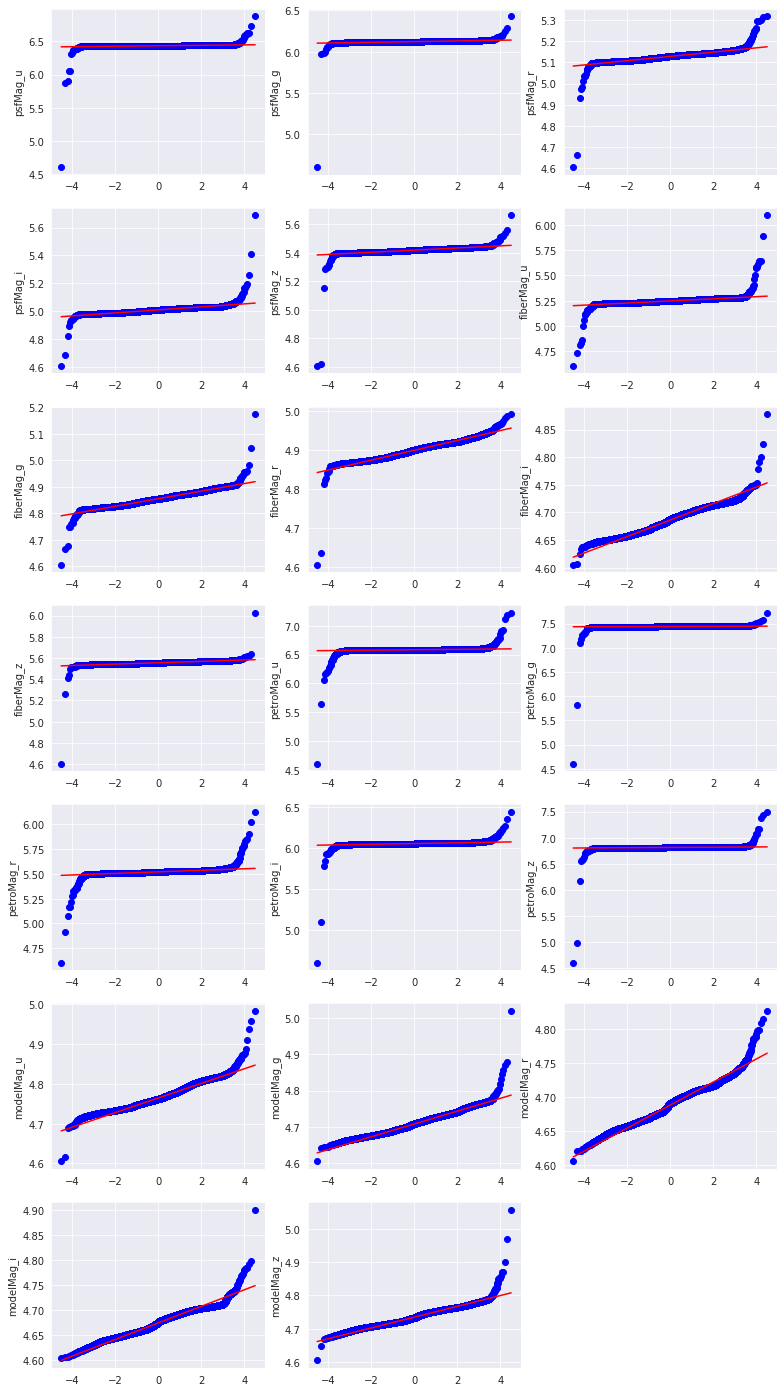

In [65]:
import scipy as sp
sns.set_style("darkgrid")
plt.figure(figsize=(13,25))
for i, col in enumerate(sc_col):
    plt.subplot(7,3,i+1)
    sp.stats.probplot(set_data.iloc[:,i], plot=plt)
    plt.title("")
    plt.xlabel("")
    plt.ylabel(col)

ValueError: ignored

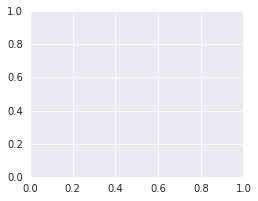

In [44]:

sns.set_style("darkgrid")
plt.figure(figsize=(13,25))
lambda_list = []
train_box = pd.DataFrame()
for i,col in enumerate(sc_col):
  ax1 = plt.subplot(7,3,i+1)
  #x, y = sp.stats.boxcox_normplot(train_x1.iloc[:,i], -2, 2)
  #plt.plot(x, y);
  y2, l = sp.stats.boxcox(train_x.iloc[:,i])
  train_box[col] = y2
  sns.distplot(y2, ax=ax1)
  #plt.axvline(x=l, color='r', ls="--");
  print(col ," optimal lambda:", l)
  lambda_list.append(l)

In [0]:
test_box = set_data.iloc[199953:,:]
train_box = set_data.iloc[:199953,:]


In [0]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
scaler =  RobustScaler()
scaler1 = MinMaxScaler()
train_x_sc = scaler.fit_transform(train_box[sc_col])
test_x_sc = scaler.transform(test_box[sc_col])
train_not_sc = scaler1.fit_transform(train_x[not_col])
test_not_sc = scaler1.transform(test_x[not_col])
train_x_sc =  pd.DataFrame(train_x_sc,columns = sc_col,index = train_box.index)
test_x_sc =  pd.DataFrame(test_x_sc,columns = sc_col,index = test_box.index)
train_not_sc =  pd.DataFrame(train_not_sc,columns = sample_submission.columns,index = train_box.index)
test_not_sc =  pd.DataFrame(test_not_sc,columns = sample_submission.columns,index = test_box.index)

In [0]:
train_x_sc = pd.concat([train_x_sc, train_not_sc],axis=1)
test_x_sc = pd.concat([test_x_sc, test_not_sc],axis=1)

In [149]:
test_x_sc.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,STAR_WHITE_DWARF,STAR_CATY_VAR,STAR_BROWN_DWARF,SERENDIPITY_RED,REDDEN_STD,STAR_BHB,GALAXY,SERENDIPITY_DISTANT,QSO,SKY,STAR_RED_DWARF,ROSAT_D,STAR_PN,SERENDIPITY_FIRST,STAR_CARBON,SPECTROPHOTO_STD,STAR_SUB_DWARF,SERENDIPITY_MANUAL,SERENDIPITY_BLUE
count,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.00000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000,10009.000000
mean,0.044802,-0.013323,-0.074182,-0.077807,0.000005,0.052058,0.003432,-0.057725,-0.048681,0.043451,0.134510,-0.092569,-0.065759,-0.027576,0.078021,0.114429,-0.010455,-0.075006,-0.044967,0.052892,0.633589,0.482564,0.463407,0.384602,0.562859,0.375423,0.448414,0.04446,0.308689,0.046258,0.452988,0.528298,0.144710,0.316782,0.391011,0.019782,0.553222,0.275002,0.313848
std,0.841886,0.997897,0.693462,0.746083,0.692239,0.829199,0.750077,0.680513,0.673595,0.678428,1.117519,9.639362,0.667316,0.662451,0.793422,0.797372,0.677304,0.622048,0.600464,0.599009,0.200049,0.249142,0.192119,0.182969,0.194156,0.185516,0.193893,0.15298,0.181140,0.114172,0.183415,0.196190,0.181807,0.180969,0.173950,0.139258,0.210344,0.231310,0.199835
min,-11.475999,-27.490376,-4.312133,-20.918637,-2.166738,-5.023012,-5.024574,-3.001125,-2.759558,-11.367765,-50.804255,-959.027353,-15.873812,-9.411692,-29.028772,-3.040251,-2.111332,-1.978956,-1.950397,-1.882602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.485422,-0.504411,-0.576146,-0.561897,-0.484416,-0.464291,-0.476686,-0.550575,-0.531739,-0.436757,-0.438804,-0.513176,-0.575122,-0.556831,-0.456400,-0.420434,-0.517261,-0.579341,-0.561819,-0.448330,0.600000,0.226804,0.369565,0.280000,0.500000,0.277778,0.347826,0.00000,0.166667,0.000000,0.361702,0.459459,0.000000,0.200000,0.291667,0.000000,0.472222,0.166667,0.200000
50%,-0.006808,0.002466,-0.003935,-0.004673,-0.007017,-0.003599,0.000929,-0.001634,-0.003538,-0.004515,0.001590,-0.001325,0.004724,-0.003227,-0.000887,0.002110,-0.002255,0.004185,-0.002230,-0.001707,0.670588,0.577320,0.478261,0.400000,0.589286,0.388889,0.478261,0.00000,0.333333,0.000000,0.468085,0.567568,0.000000,0.333333,0.416667,0.000000,0.583333,0.166667,0.300000
75%,0.513681,0.508129,0.417949,0.445131,0.514025,0.536645,0.534556,0.444912,0.467960,0.556325,0.563149,0.497661,0.416865,0.444472,0.546239,0.578927,0.493454,0.414220,0.440824,0.549881,0.741176,0.701031,0.586957,0.480000,0.678571,0.500000,0.565217,0.00000,0.416667,0.000000,0.574468,0.648649,0.200000,0.466667,0.500000,0.000000,0.694444,0.333333,0.400000
max,6.615144,56.837544,4.856568,11.094598,6.417301,7.983625,9.906636,3.697530,4.670052,3.030929,17.137208,29.481295,7.281307,10.869161,18.281197,4.276055,3.083213,2.716868,2.522600,1.990481,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=0.1, random_state=42)

for train_index, test_index in split.split(train_x_sc, train_y):
    x_train, y_train = train_x_sc.loc[train_index], train_y[train_index]
    x_val, y_val = train_x_sc.loc[test_index] , train_y[test_index]

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
x_train_pc = pca.fit_transform(x_train[sc_col])
x_train_pc = pd.DataFrame(x_train_pc,index=x_train.index)
# x_train_pc = pd.concat([x_train_pc,x_train[not_col]],axis=1)
X = x_train.iloc[:2000,:]
y = y_train[:2000]
# tsne = TSNE(n_components=3, random_state=42)
# X_reduced = tsne.fit_transform(X)
# plt.figure(figsize=(13,10))
# plt.scatter(X_reduced[:, 1], X_reduced[:, 2], c=y, cmap="jet")
# plt.colorbar()

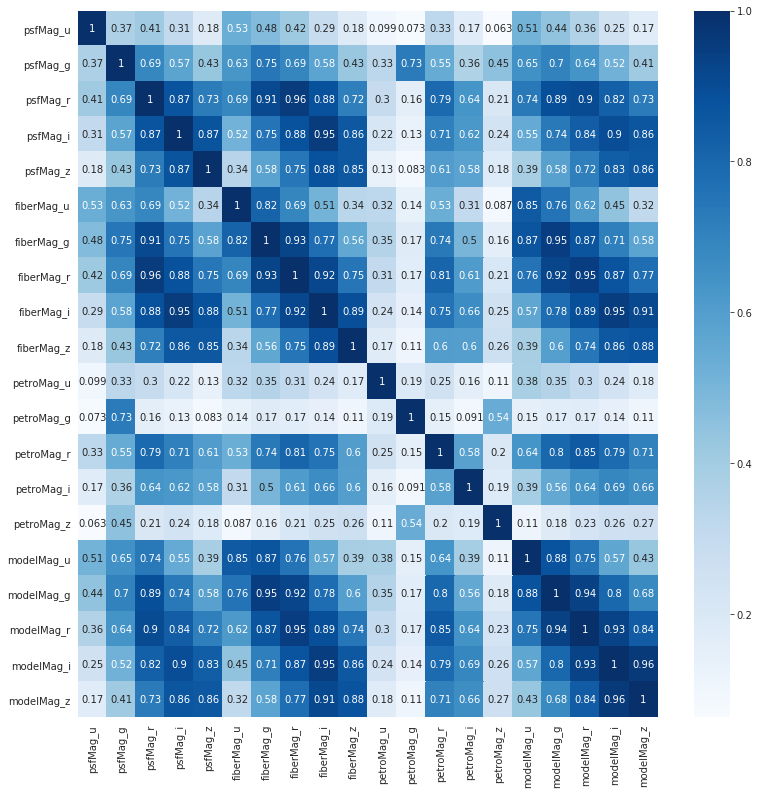

In [162]:
corrmat = train_x_sc[sc_col].corr()
plt.figure(figsize=(13,13))
g = sns.heatmap(corrmat,annot=True,cmap="Blues")

In [138]:
y_train.value_counts()

8     42225
6     31733
18    18492
15    12435
4     12424
10    11687
5     11470
13     6062
11     5589
1      5530
7      3955
14     2768
3      2177
0      1836
16      981
2       425
9       108
17       52
12       11
Name: type_num, dtype: int64

In [158]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
X_samp, y_samp = SMOTETomek(random_state=123, smote=SMOTE(sampling_strategy='auto', ratio={2:600,17:100,12:40}), 
                            tomek=TomekLinks(sampling_strategy='auto', ratio = {8:42000,6:31000,18:18000})).fit_sample(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


KeyboardInterrupt: ignored

In [0]:
import lightgbm as lgb
def build_model(sub_sample_for_bin1, num_leaves1, max_depth1,min_child_weight1, min_data_in_leaf1, min_split_gain1, min_child_samples1):
  model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=num_leaves1,  min_split_gain=  min_split_gain1,
                               min_data_in_leaf = min_data_in_leaf1,
                               max_depth= max_depth1, learning_rate=0.01, n_estimators=3000, 
                               subsample_for_bin=sub_sample_for_bin1, objective='multiclass', 
                               min_child_weight=min_child_weight1, min_child_samples=min_child_samples1
                               ,n_jobs=-1, random_state=42)
  return model
def learning_rate_001_decay_power_099(current_iter):
    base_learning_rate = 0.01
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3
def fit_with(num_leaves1, max_depth1,min_child_weight1, min_data_in_leaf1, min_split_gain1,min_child_samples1):
    model = build_model(2500000, int(num_leaves1), int(max_depth1),min_child_weight1, int(min_data_in_leaf1), min_split_gain1,int(min_child_samples1))
    fit_model = model.fit(x_train,y_train,eval_set = [(x_val,y_val)], verbose= 500,
                          early_stopping_rounds=100)
    y_pred = model.predict_proba(x_val)
    
    return -log_loss(y_en.toarray(),y_pred)

# lgb_clf1 = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=60, max_depth=-1, learning_rate=0.003, 
#                              n_estimators=3000, subsample_for_bin=400000, objective='multiclass', min_split_gain=0.15, reg_alpha = 0.1, 
#                              min_child_weight=5e-3, min_child_samples=10,n_jobs=-1, random_state=42,)
# lgb_model1 = lgb_clf1.fit(x_train, y_train, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

In [0]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
encoder1 = OneHotEncoder()
y_en = encoder1.fit_transform(np.array(y_val).reshape(-1,1))

In [153]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {
    'num_leaves1':  (35, 70),
    'max_depth1': (15, 50),
    'min_child_weight1': (0.001, 1),                                              
    'min_child_samples1' : (5, 25),
    'min_data_in_leaf1' : (1,10),
    'min_split_gain1' : (0.05,0.5),
}

bayes_optimizer = BayesianOptimization(
    f=fit_with,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    # random_state=1
)

bayes_optimizer.maximize(init_points=15, n_iter=15)
for i, res in enumerate(bayes_optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

|   iter    |  target   | max_de... | min_ch... | min_ch... | min_da... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's multi_logloss: 0.413833
[1000]	valid_0's multi_logloss: 0.380715
[1500]	valid_0's multi_logloss: 0.376597
[2000]	valid_0's multi_logloss: 0.37521
Early stopping, best iteration is:
[2187]	valid_0's multi_logloss: 0.374946
|  1        | -0.3749   |  38.38    |  7.03     |  0.1149   |  7.228    |  0.2764   |  49.64    |
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's multi_logloss: 0.422624
[1000]	valid_0's multi_logloss: 0.38607


KeyboardInterrupt: ignored

In [0]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {
    'num_leaves1':  (35, 70),
    'max_depth1': (15, 50),
    'min_child_weight1': (0.001, 1),                                              
    'min_child_samples1' : (5, 25),
    'min_data_in_leaf1' : (1,10),
    'min_split_gain1' : (0.05,0.5),
}

bayes_optimizer = BayesianOptimization(
    f=fit_with,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    # random_state=1
)

bayes_optimizer.maximize(init_points=15, n_iter=15)
for i, res in enumerate(bayes_optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

|   iter    |  target   | max_de... | min_ch... | min_ch... | min_da... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's multi_logloss: 0.427756
[1000]	valid_0's multi_logloss: 0.391227


KeyboardInterrupt: ignored

In [155]:
lgb_clf1 = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=80, max_depth=50, learning_rate=0.005, min_data_in_leaf = 10,
                             n_estimators=10000, subsample_for_bin=500000, objective='multiclass', min_split_gain=0.5, reg_alpha = 0.01, reg_lambda = 0.01,
                             min_child_weight=0.8, min_child_samples=20,n_jobs=-1, random_state=123,)
lgb_model1 = lgb_clf1.fit(x_train, y_train, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

Training until validation scores don't improve for 50 rounds.
[200]	valid_0's multi_logloss: 0.924595
[400]	valid_0's multi_logloss: 0.599497
[600]	valid_0's multi_logloss: 0.477571
[800]	valid_0's multi_logloss: 0.426629
[1000]	valid_0's multi_logloss: 0.401906
[1200]	valid_0's multi_logloss: 0.389331
[1400]	valid_0's multi_logloss: 0.382352
[1600]	valid_0's multi_logloss: 0.378256
[1800]	valid_0's multi_logloss: 0.376087
[2000]	valid_0's multi_logloss: 0.37474
[2200]	valid_0's multi_logloss: 0.374045
[2400]	valid_0's multi_logloss: 0.373599
[2600]	valid_0's multi_logloss: 0.373406
[2800]	valid_0's multi_logloss: 0.373245
[3000]	valid_0's multi_logloss: 0.373141
[3200]	valid_0's multi_logloss: 0.373058
Early stopping, best iteration is:
[3281]	valid_0's multi_logloss: 0.373057


In [0]:
y_test = lgb_model1.predict_proba(test_x_sc)
submission = pd.DataFrame(data=y_test, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('/gdrive/My Drive/Data/submission2.csv', index=True)

In [1]:
y_pred = lgb_model1.predict(x_train)
plt.figure(figsize=(13,13))
ax = sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt="d" 
                  ,yticklabels=sample_submission.columns, xticklabels=sample_submission.columns
                )

NameError: ignored

In [0]:
from sklearn.metrics import confusion_matrix